/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Validation Results (Logistic Regression) ===
              precision    recall  f1-score   support

          -1      0.769     0.935     0.844       448
           0      0.382     0.271     0.317        48
           1      0.675     0.325     0.439       160

    accuracy                          0.738       656
   macro avg      0.609     0.510     0.533       656
weighted avg      0.718     0.738     0.707       656

=== Test Results (Logistic Regression) ===
              precision    recall  f1-score   support

          -1      0.725     0.957     0.825       417
           0      0.552     0.302     0.390        53
           1      0.756     0.316     0.445       187

    accuracy                          0.721       657
   macro avg      0.678     0.525     0.554       657
weighted avg      0.720     0.721     0.682       657

Confusion Matrix (LR) on Test:
[[399   7  11]
 [ 29  16   8]
 [122   6  59]]


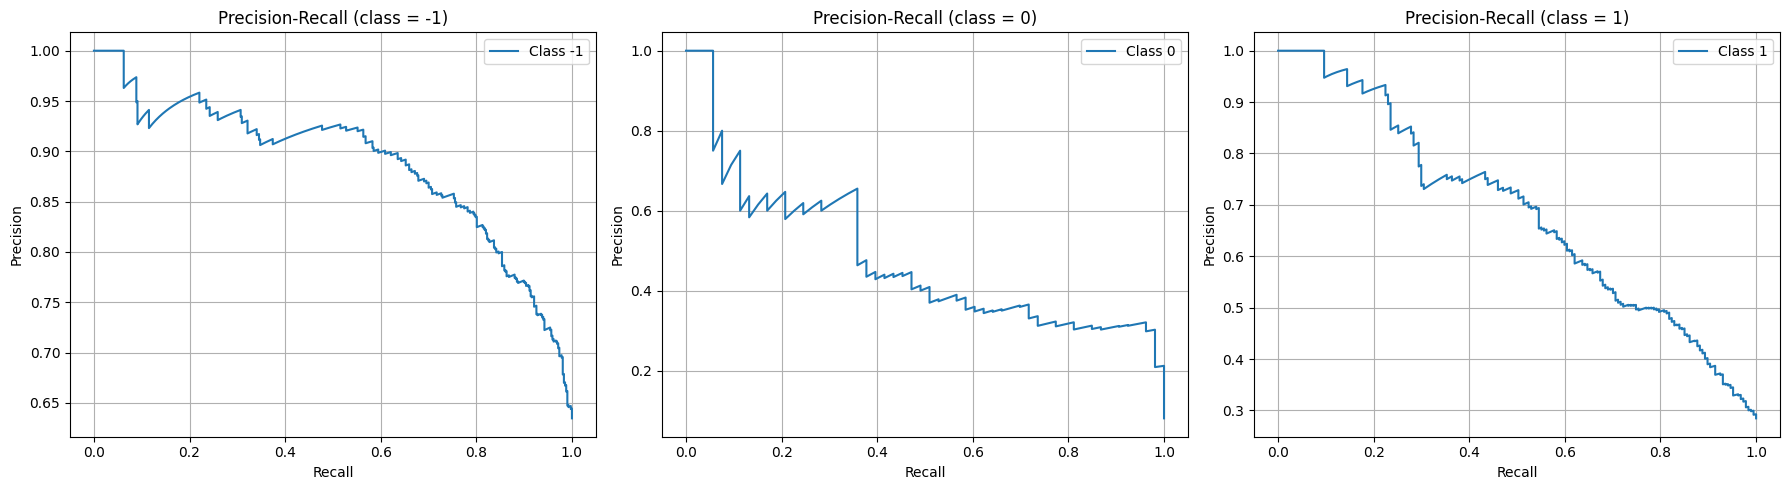

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.preprocessing import label_binarize

# 1. LOAD AND MERGE
DATA_DIR = "data"

mtcsd_train = pd.read_csv(os.path.join(DATA_DIR, "MT-CSD_train.csv"))
mtcsd_dev   = pd.read_csv(os.path.join(DATA_DIR, "MT-CSD_dev.csv"))
mtcsd_test  = pd.read_csv(os.path.join(DATA_DIR, "MT-CSD_test.csv"))

vast_train = pd.read_csv(os.path.join(DATA_DIR, "VAST_train.csv"))
vast_dev   = pd.read_csv(os.path.join(DATA_DIR, "VAST_dev.csv"))
vast_test  = pd.read_csv(os.path.join(DATA_DIR, "VAST_test.csv"))

ruw_train = pd.read_csv(os.path.join(DATA_DIR, "Russia-Ukraine_War_train.csv"))
ruw_dev   = pd.read_csv(os.path.join(DATA_DIR, "Russia-Ukraine_War_dev.csv"))
ruw_test  = pd.read_csv(os.path.join(DATA_DIR, "Russia-Ukraine_War_test.csv"))

'''fnc_train = pd.read_csv(os.path.join(DATA_DIR, "fnc_train_translated.csv"))
fnc_val   = pd.read_csv(os.path.join(DATA_DIR, "fnc_validation_translated.csv"))
fnc_test  = pd.read_csv(os.path.join(DATA_DIR, "fnc_test_translated.csv"))'''

vt_train = pd.read_csv(os.path.join(DATA_DIR, "Various_Tweets_(2023)_train.csv"))
vt_val   = pd.read_csv(os.path.join(DATA_DIR, "Various_Tweets_(2023)_dev.csv"))
vt_test  = pd.read_csv(os.path.join(DATA_DIR, "Various_Tweets_(2023)_test.csv"))

train_df = pd.concat([mtcsd_train, vast_train, ruw_train, vt_train], ignore_index=True)
val_df   = pd.concat([mtcsd_dev,   vast_dev,   ruw_dev, vt_val],   ignore_index=True)
test_df  = pd.concat([mtcsd_test,  vast_test,  ruw_test, vt_test],  ignore_index=True)

# 2. COMBINE TEXT
def combine_text(row):
    return f"Target: {row['Target']} [SEP] Context: {row['Context']} [SEP] Text: {row['Text']}"

train_df["combined_text"] = train_df.apply(combine_text, axis=1)
val_df["combined_text"]   = val_df.apply(combine_text, axis=1)
test_df["combined_text"]  = test_df.apply(combine_text, axis=1)

# 3. TF-IDF
vectorizer = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    lowercase=True
)
X_train = vectorizer.fit_transform(train_df["combined_text"])
X_val   = vectorizer.transform(val_df["combined_text"])
X_test  = vectorizer.transform(test_df["combined_text"])

y_train = train_df["Stance"].values
y_val   = val_df["Stance"].values
y_test  = test_df["Stance"].values

# 4. TRAIN LOGISTIC REGRESSION
clf = LogisticRegression(
    max_iter=200,
    solver='lbfgs',
    multi_class='multinomial',
    random_state=42
)
clf.fit(X_train, y_train)

# 5. VALIDATION
y_val_pred = clf.predict(X_val)
print("=== Validation Results (Logistic Regression) ===")
print(classification_report(y_val, y_val_pred, digits=3))

# 6. TEST
y_test_pred = clf.predict(X_test)
print("=== Test Results (Logistic Regression) ===")
print(classification_report(y_test, y_test_pred, digits=3))

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (LR) on Test:")
print(cm)

# 7. PRECISION-RECALL CURVE
unique_labels = sorted(list(set(y_train)))  # [-1, 0, 1]
y_test_binarized = label_binarize(y_test, classes=unique_labels)
y_score = clf.predict_proba(X_test)  # [n_samples, 3]

plt.figure(figsize=(18, 5))
for i, label_val in enumerate(unique_labels):
    y_true = y_test_binarized[:, i]
    y_scores = y_score[:, i]

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    plt.subplot(1, len(unique_labels), i+1)
    plt.plot(recall, precision, label=f"Class {label_val}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall (class = {label_val})")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

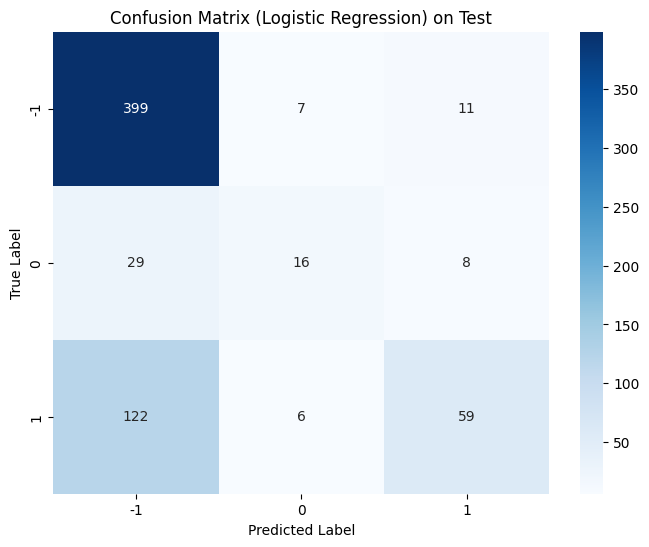

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix data
confusion_matrix = np.array([[399, 7, 11], [29, 16, 8], [122, 6, 59]])
class_labels = ['-1', '0', '1']  # Class labels

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels, title, and color bar
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Logistic Regression) on Test")
plt.show()
